Фактически, между распознаванием объектов и распознаванием изображений нет реальной разницы. Обе технологии могут распознавать определенные целевые объекты через специальные алгоритмы, такие как глубокое обучение. Они тесно связаны с компьютерным зрением, которое мы определяем как искусство и науку заставлять компьютеры понимать изображения.

В этом ядре мы рассмотрим некоторые основные концепции распознавания объектов:

Что такое распознавание объектов/изображений?
Распознавание объектов включает в себя распознавание, идентификацию и локализацию объектов на изображении с определенной степенью уверенности.

В этом процессе четыре основные задачи:

Классификация.
Маркировка.
Обнаружение.
Сегментация.
Классификация и маркировка
Один из важных задач распознавания объектов - определить, что находится на изображении и с каким уровнем уверенности.

Механизм этой задачи прост. Он начинается с определения онтологии, то есть класса объектов для обнаружения. Затем классификация и маркировка идентифицируют, что находится на изображении, и связанный уровень уверенности.

В то время как классификация распознает только один класс объектов, маркировка может распознавать несколько классов для данного изображения.

При классификации алгоритм будет помнить только то, что на изображении есть собака, игнорируя все остальные классы.

При маркировке он будет пытаться вернуть все лучшие классы, соответствующие изображению.

Обнаружение и сегментация
Определив, что находится на изображении, мы хотим определить местоположение объектов. Существует два способа сделать это: обнаружение и сегментация.

Обнаружение выдает прямоугольник, также называемый ограничивающим прямоугольником, где находятся объекты. Это очень надежная технология, склонная к незначительным ошибкам и неточностям.

Сегментация идентифицирует объект

In [ ]:
# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Import Warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
# Import tensorflow as the backend for Keras
from keras import backend as K
# K.set_image_dim_ordering('tf')
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.callbacks import TensorBoard
# Import required libraries for cnfusion matrix
from sklearn.metrics import classification_report,confusion_matrix
import itertools
import pickle
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = os.getcwd()
# Define data path
data_path = '/content/drive/MyDrive/FORUM_PROFI/train/'
# data_dir_list = os.listdir(data_path)
data_dir_list = ['0', '1', '2', '3', '4']

In [ ]:
img_rows=128
img_cols=4096
num_channel=1
num_epoch=100
# Define the number of classes
num_classes = 7

Assigning Labels & define the number of classes

In [ ]:
Y = np_utils.to_categorical(data_dir_list, num_classes)

In [ ]:
def read_names(cls: str):
  name_lis = []
  for filename in os.listdir(''.join(['/content/drive/MyDrive/FORUM_PROFI/train/', cls])):
    name_lis.append(filename)
  return name_lis


def read_data(idx: list):
    data_x, data_y, wrong_sizes = [], [], []
    for filename in idx[:100]:
      if filename == '6794439.pkl' or filename == '7270902.pkl':
        continue
      else:
        with open(f'/content/drive/MyDrive/FORUM_PROFI/train/X/{filename}', 'rb') as f:
            x = pickle.load(f)
        with open(f'/content/drive/MyDrive/FORUM_PROFI/train/Y/{filename}', 'rb') as f:
            y_element, y_defect = pickle.load(f)
        if len(x) != 128 or len(x[0]) != 4096:
                wrong_sizes.append(filename)
                continue
        data_x.append(x)
        data_y.append((y_element, y_defect))

    print(wrong_sizes)
    return data_x, data_y

# Example usage
x, y = read_data(read_names('X'))

['7313245.pkl', '7441833.pkl', '7453310.pkl', '7600578.pkl', '8020871.pkl', '8045290.pkl', '8137834.pkl', '8147042.pkl']


train dataset

In [ ]:
x = np.array(x, dtype = np.float64)
y = np.array(y, dtype = np.float64)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [ ]:
# Добавляем размерность канала
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [ ]:
print("X_train shape = {}".format(X_train.shape))
print("X_test shape = {}".format(X_test.shape))

X_train shape = (73, 128, 4096, 1)
X_test shape = (19, 128, 4096, 1)


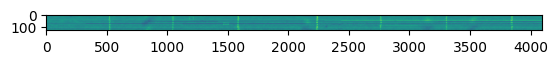

In [ ]:
image = X_train[0].reshape((128,4096))
plt.imshow(image)
plt.show()

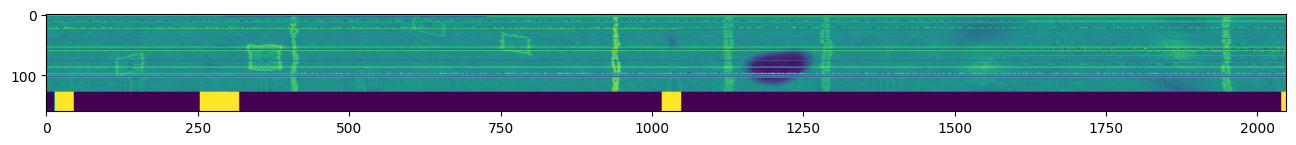

In [ ]:
def read_data(idx: int):
  with open(f"/content/drive/MyDrive/FORUM_PROFI/train/X/{idx}.pkl", "rb") as f:
    x = pickle.load(f)
  with open(f"/content/drive/MyDrive/FORUM_PROFI/train/Y/{idx}.pkl", "rb") as f:
    y_elements, y_defects = pickle.load(f)
  return x, y_elements, y_defects

x, y_elem, y_def = read_data(1929865)

img = np.zeros((x.shape[0] + 32, x.shape[1]))
img[:x.shape[0]] = x
img[x.shape[0]:][:, y_def > 0.5] = 1.
plt. figure(figsize=(16, 9))
plt.imshow(img[:, 512:512+2048])
#plt.imshow(img)

### 2. Designing and training a CNN model in Keras

In [ ]:
#Initialising the input shape
input_shape= X_train[0].shape
input_shape

(128, 4096, 1)

In [ ]:
# Design the CNN Sequential model
cnn_model = Sequential([
Convolution2D(32, 4, 4, activation='relu', input_shape=input_shape),
Convolution2D(32, 4, 4, activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
Dropout(0.5),
Flatten(),
Dense(128, activation='relu'),
Dropout(0.5),
Dense(num_classes, activation='softmax')
])

**Compiling the model**

In [ ]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=["accuracy"])

### View Model Configuration

In [ ]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 1024, 32)      544       
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 256, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 128, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 4, 128, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               2097280   
                                                      

### Train the model

In [ ]:
trans = np.transpose(X_train)
trans_test = np.transpose(X_test)
trans.shape

(1, 4096, 128, 73)

In [ ]:
print(y_train.shape) #(73, 2, 4096)
print(trans.shape) # (1, 4096, 128, 73)
print(trans_test.shape) # (1, 4096, 128, 19)
print(y_test.shape) # (19, 2, 4096)

(73, 2, 4096)
(1, 4096, 128, 73)
(1, 4096, 128, 19)
(19, 2, 4096)


In [ ]:
# Проверяем размерности входных и выходных данных
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Устанавливаем batch_size
batch_size = 8

# Определяем количество образцов в тренировочных и тестовых данных
num_train_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]

# Вычисляем количество шагов на эпоху
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_test_samples // batch_size

# Запускаем обучение (проблема с размерностью)
hist = cnn_model.fit(X_train, y_train, batch_size=batch_size, verbose=1,
                     validation_data=(X_test, y_test),
                     steps_per_epoch=steps_per_epoch,
                     validation_steps=validation_steps)

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(num_epoch)

### 3. Plotting the Loss and Accuracy curve
#### Visualizing Training Loss & Validation Loss

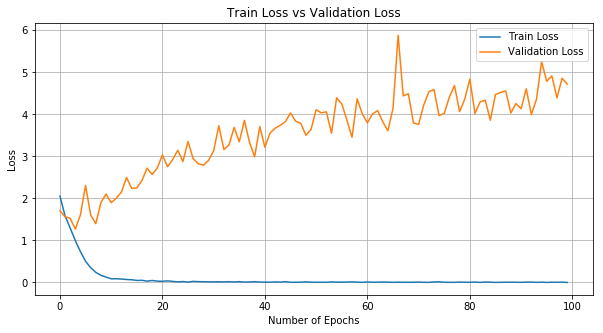

In [ ]:
plt.figure(1,figsize=(10,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs Validation Loss')
plt.grid(True)
plt.legend(['Train Loss','Validation Loss'])
plt.style.use(['classic'])

#### Visualizing Training Accuracy & Validation Accuracy

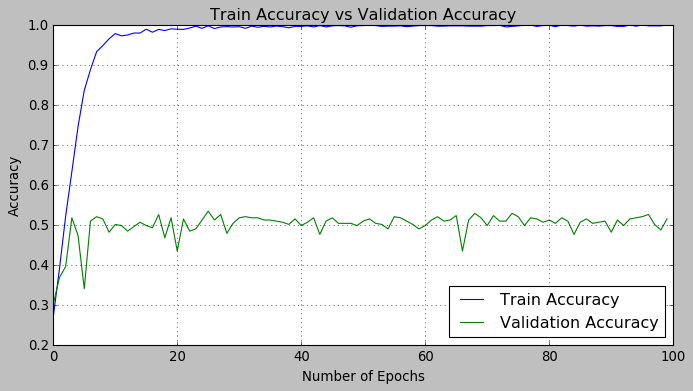

In [ ]:
plt.figure(2,figsize=(10,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs Validation Accuracy')
plt.grid(True)
plt.legend(['Train Accuracy','Validation Accuracy'],loc=4)
plt.style.use(['classic'])

### 4. Evaluating the model & Predicting the output class of a test image

In [ ]:
score = cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])

Test Loss: 4.719305637470573
Test Accuracy: 0.5152354575590413


Now let use a test image and predict the probability of this image belonging to which class.Let us find out

### 6. Plotting the confusion matrix to observe the result

In [ ]:
print('Confusion Matrix \n')
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

Confusion Matrix 

[[51  2  5  3  3  4  4]
 [ 8 10 22  1  1  0  2]
 [ 2 14 48 11  0  1  0]
 [ 3  1 29 13  1  0  1]
 [ 5  0  0  0 35  3  1]
 [10  0  0  0  1 23  1]
 [19  3  3  1 10  0  6]]


From the above confusion matrix each row represents a class .For example let us look at the first row where it shows 37 images are classified for class 0 (flowers) and rest across other classes. To visualise this in a more understandable format let us plot it using matplotlib library as below

**Plotting the confusion matrix**

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix with Normalization")
    else:
        print('Confusion matrix without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
np.set_printoptions(precision=2)
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>